In [2]:
# Install ReadVTK with: import Pkg; Pkg.add("ReadVTK")
using ReadVTK

# Loading VTI files into Julia

function read_vti( filename, typ=Float64 )
    
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    vtk_data       = get_data( vtk_data_array ); 
    data_reshaped  = reshape(vtk_data, (data_size .- 1 )...); 
    return typ.( data_reshaped ) 
end


read_vti (generic function with 2 methods)

In [3]:
read_vti("E:\\PhD\\Headon_results\\headon_data\\tp0.vti")

1024×1024×14 Array{Float64, 3}:
[:, :, 1] =
  48.0   181.0  507.0    55.0   47.0  …    62.0    63.0    22.0    20.0
  41.0    81.0   65.0   496.0   38.0      386.0   214.0   144.0    65.0
  96.0    46.0   74.0   300.0   40.0        7.0    49.0   208.0   306.0
  66.0    37.0   80.0   597.0  879.0       37.0    27.0   879.0   769.0
  53.0   452.0  761.0   367.0   29.0      127.0    19.0   844.0   604.0
 760.0    36.0   22.0   731.0   17.0  …    27.0    91.0   212.0    49.0
 190.0  1004.0   46.0   379.0  576.0      430.0  1331.0   104.0    64.0
  29.0    81.0   14.0    30.0   38.0      700.0    88.0    64.0    37.0
 324.0   711.0  300.0   520.0   44.0       70.0   197.0    63.0    75.0
  53.0   193.0   64.0   851.0   61.0       76.0    73.0   254.0    62.0
 353.0    27.0   64.0    51.0  532.0  …    55.0   495.0    72.0   538.0
  44.0  1094.0   50.0    77.0   53.0       82.0    52.0    60.0    50.0
 170.0   480.0   72.0    72.0  996.0       51.0   721.0    37.0   114.0
   ⋮                

In [4]:
# Extract the single i-th layer from vti files and save the image data
# over all time points locally into a .h5 file.

using HDF5

function extract_layer(folder_path::String, i::Int64)
    
    # variable folder_path should be in type string.
    n_files = length(readdir(folder_path))
    
    # Storing data from a single layer over time in an Array. 
    layer_data = Matrix{Float64}[]
    
    #for file in readdir(folder_path)
    for t in 0:n_files-1
        # file is in type String. Open the file.
        cell_data = read_vti(folder_path*"\\tp"*string(t)*".vti")
        # Choose the i-th layer from the cell data and append it 
        # to layer_data.
        push!(layer_data, cell_data[:,:,i])
    end
    
    # Convert the layer_data to 3D array structure
    # (width, height, timepoint) dimensional.
    l_data = reduce((x,y) -> cat(x,y,dims=3), layer_data)

    # Save the data in .h5 file with package HDF5.jl
    h5open("headon_layer_"*string(i)*".h5", "w") do file
    write(file, "data", l_data)  
    end

end

extract_layer (generic function with 1 method)

In [6]:
extract_layer("E:\\PhD\\Headon_results\\headon_data", 1)

In [1]:
# Read h5 file in which image data is saved. 
using HDF5

function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end


read_h5 (generic function with 1 method)

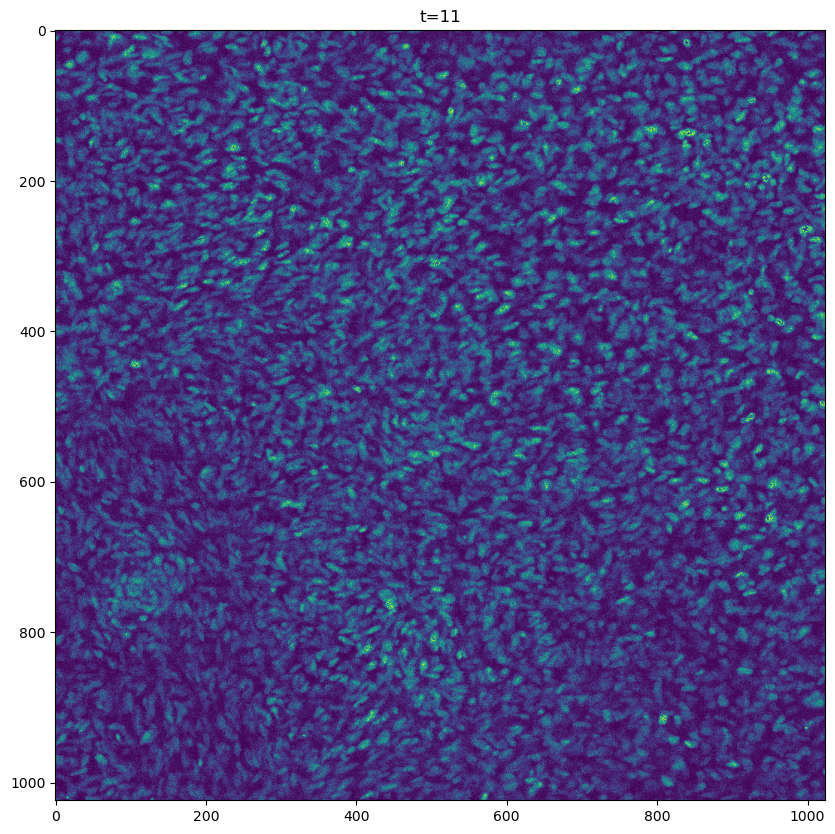

In [8]:
# Function for presenting single layer dynamics over time as .gif

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images

# Update function for video.

# Making video.
#function single_layer_dyn(folder_path::String, filename::String)
    # Read the data saved in .h5 file.
data = read_h5("headon_layer_5.h5")

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    PyPlot.clf()
    PyPlot.title("t=$(i+1)")
    imshow(Float64.(Gray.(data[:, :, i+1])))
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=200, repeat=false, blit=false)
myanim[:save]("headon_layer_5.gif", writer="pillow")
#end

In [18]:
#=

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot

function make_frame(i, data)
    imshow(data[:, :, i+1])
end

function single_layer_dyn(open_filename::String, save_filename::String)
    data = read_h5(open_filename*".h5")
    
    fig = PyPlot.figure(figsize=(10, 10))
    
    myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=200, repeat=false, blit=false)
    myanim[:save](save_filename*".gif", writer="pillow")
end

=#

In [17]:
#=
single_layer_dyn("headon_layer_5", "headon_layer_5")
=#

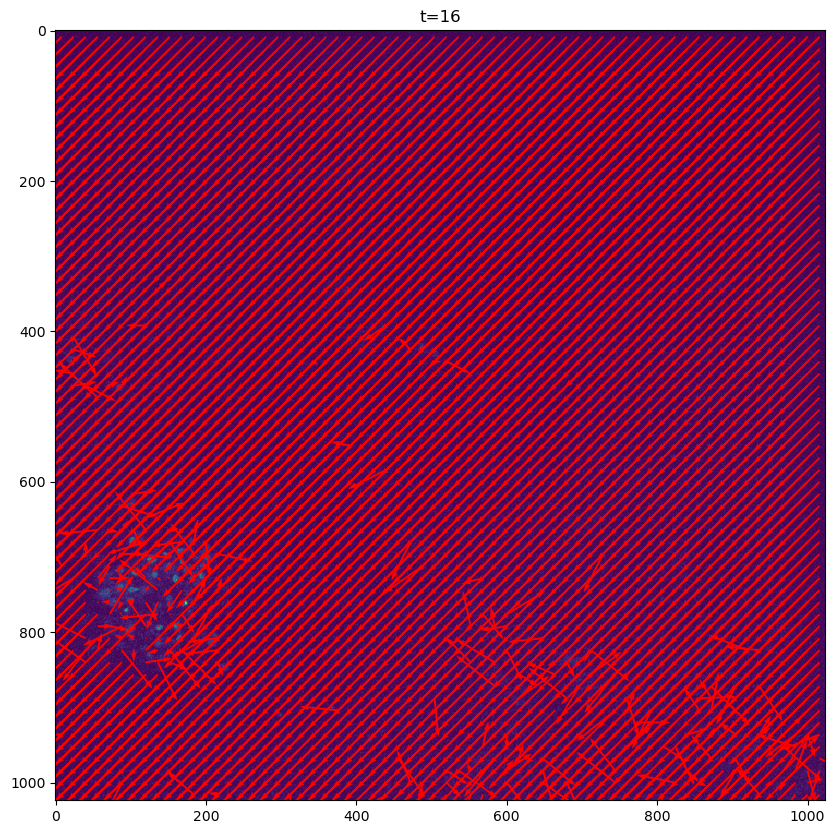

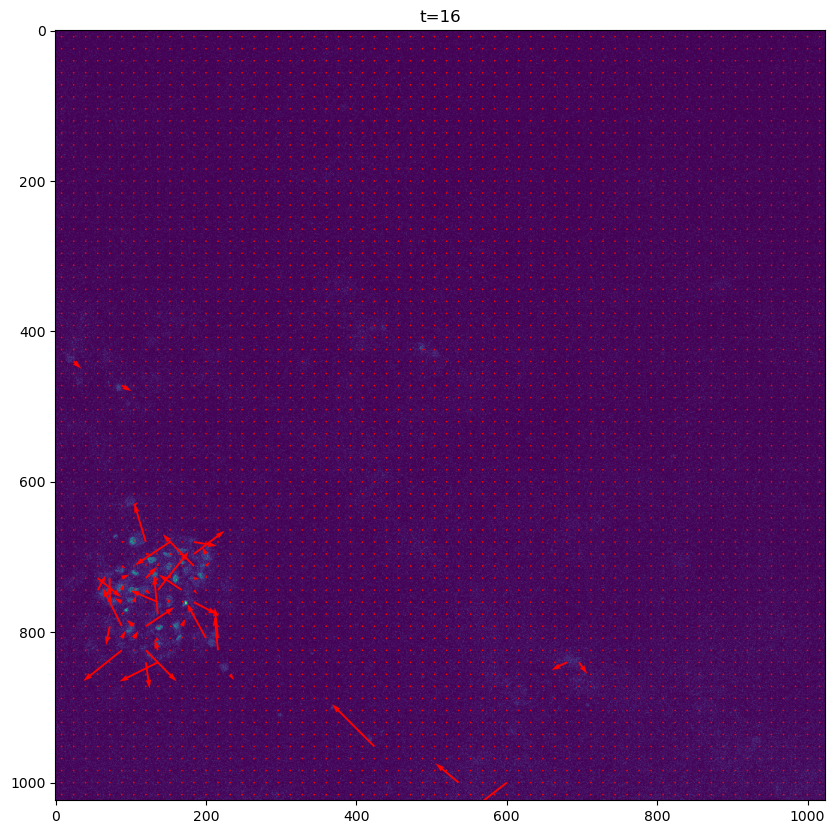

In [14]:
# Function for PIV vector fields. (Causion the orientation y-axis!)

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
using multi_quickPIV
#using VideoIO, FFMPEG
using ImageBinarization
using ImageAnalysis

# intensity of a subregion. 
function integralArea( intArr::Matrix{Float64}, TL, BR)
    area = intArr[BR[1],BR[2]] - intArr[BR[1],TL[2]] - intArr[TL[1],BR[2]] + intArr[TL[1],TL[2]]
    return area
end

l_data = read_h5("headon_layer_1.h5")

#params = multi_quickPIV.setPIVParameters(interSize=(32,32), searchMargin=(16,16))#, step=(16,16), threshold=1000) 
params = multi_quickPIV.setPIVParameters(interSize=(16, 16))
IA_size = multi_quickPIV._isize(params)[1:2]
IA_step = multi_quickPIV._step(params)[1:2]

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i) # Due to Python function i begins with 0!
    
    PyPlot.clf()
    
    img1 = Float64.(Gray.(l_data[:, :, i+1]))
    img2 = Float64.(Gray.(l_data[:, :, i+2]))
    
    # Mask 
    img1_b = binarize(img1, Polysegment())
    img2_b = binarize(img2, Polysegment())
    
    # Doing PIV
    VF, SN = multi_quickPIV.PIV(img1_b, img2_b, params)
    
    U = VF[ 1, :, : ]
    V = VF[ 2, :, : ]
    
    xgrid = [(x-1)*IA_step[2] + div(IA_size[2],2) for y in 1:size(U,1), x in 1:size(U,2)] 
    ygrid = [(y-1)*IA_step[1] + div(IA_size[1],2) for y in 1:size(U,1), x in 1:size(U,2)]
    
    # Setting arrows on blank IA to be zero.
    sum_img = ImageAnalysis.integralArray(img1_b, typ = Float64, fun = (x) -> (x))
    width = Integer(IA_size[1]/2)
    #sum_subarea = zeros(Float64, size(xgrid))
    w = size(img1_b)[1]
    h = size(img1_b)[2]
    
    for x in 1:size(U)[1]
        for y in 1:size(U)[2]

            col = xgrid[x, y]
            row = ygrid[x, y]

            TL = max(1, row-width), max(1, col-width)
            BR = min(h, row+width), min(w, col+width)

            if integralArea(sum_img, TL, BR) <= 3
                U[x, y] = 0
                V[x, y] = 0
            end

            #sum_subarea[x, y] = integralArea(sum_img, TL, BR)
        end
    end

    PyPlot.title("t=$(i+1)")
    imshow(img1)
    #imshow(img1_b)
    PyPlot.quiver( xgrid, ygrid, V, -1 .* U, color="red", scale=200)
    #PyPlot.quiver( xgrid, ygrid, U, V, color="red", scale=200 )

end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(l_data,3)-1, 
                            interval=400)
myanim[:save]("headon_1_piv_f.gif", writer="pillow")
#myanim[:save]("test_anim.mp4", writer="ffmpeg")
#myanim[:save]("test_anim.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

In [13]:
params = multi_quickPIV.setPIVParameters()

multi_quickPIV.PIVParameters(multi_quickPIV.NSQECC(), true, true, false, (32, 32, 32), (10, 10, 10), (0, 0, 0), nothing, 1, false, multi_quickPIV.var"#2#4"(), -1.0, 3, 0.5)